In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Image
from matplotlib import gridspec
import scanpy as sc
from pathlib import Path
import scanpy as sc
import anndata
import muon 
from cnmf import cNMF
import os

/home/users/ymo/.local/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
numiter=20  
numhvgenes=5451  
K = [30, 50, 60, 80, 100, 200, 250, 300] 
seed = 14
loss = 'frobenius'
init = 'random'
algo = 'cd'
max_NMF_iter = 1000
sel_thresh = 2.0

counts_fn = "/oak/stanford/groups/engreitz/Users/ymo/NMF_re-inplementing/Cell_data/100k_250genes.h5ad"
output_directory = "/oak/stanford/groups/engreitz/Users/ymo/NMF_re-inplementing/Results/Consensus_across_methods/"
run_name = "online_halsvar_cd_e7"

In [3]:

cnmf_obj = cNMF(output_dir=output_directory, name=run_name)


In [4]:
cnmf_obj.prepare(counts_fn= counts_fn, components= K, n_iter= numiter, densify=False, tpm_fn=None, seed= seed,
                beta_loss = loss, num_highvar_genes=numhvgenes, genes_file=None,
                alpha_usage=0.0, alpha_spectra=0.0, init=init, max_NMF_iter=max_NMF_iter, algo = algo)

/oak/stanford/groups/engreitz/Users/ymo/Tools/sk_cNMF/src/cnmf/cnmf.py:616: UserWarning: 160 runs already appear completed. If this is unexpected, consider
            re-initializing the cnmf object with a different run name or output directory
  warnings.warn(message, UserWarning)


In [ ]:
cnmf_obj.factorize(total_workers = 1)

In [5]:
cnmf_obj.combine()

Combining factorizations for k=30.
Combining factorizations for k=50.
Combining factorizations for k=60.
Combining factorizations for k=80.
Combining factorizations for k=100.
Combining factorizations for k=200.
Combining factorizations for k=250.
Combining factorizations for k=300.


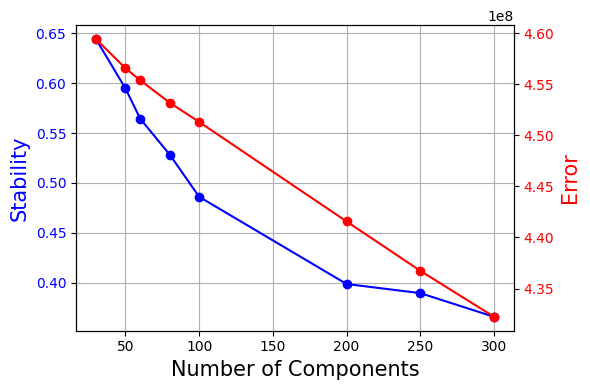

In [6]:
cnmf_obj.k_selection_plot()

In [7]:
from tqdm.auto import tqdm

def run_cnmf_consensus(cnmf_obj=None, output_dir=None, name=None, 
                       components=[7,8,9,10], density_thresholds=[0.01, 0.05, 2.0]):

    if cnmf_obj is None:
        cnmf_obj = init_cnmf_obj(output_dir=output_dir, name=name)

    for k in tqdm(components, desc='Running cNMF'):
        for thresh in density_thresholds:
            cnmf_obj.consensus(k=k, density_threshold=thresh, show_clustering=True)
    

In [8]:
# Consensus plots with all k to choose thresh

run_cnmf_consensus(cnmf_obj, 
                components=K, 
                density_thresholds=[sel_thresh])

Running cNMF:   0%|          | 0/8 [00:00<?, ?it/s]/home/users/ymo/.local/lib/python3.9/site-packages/scanpy/preprocessing/_scale.py:318: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
Running cNMF:  12%|█▎        | 1/8 [00:54<06:18, 54.05s/it]/home/users/ymo/.local/lib/python3.9/site-packages/scanpy/preprocessing/_scale.py:318: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
Running cNMF:  25%|██▌       | 2/8 [02:32<08:00, 80.05s/it]/home/users/ymo/.local/lib/python3.9/site-packages/scanpy/preprocessing/_scale.py:318: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
Running cNMF:  38%|███▊      | 3/8 [04:44<08:39, 103.97s/it]/home/users/ymo/.local/lib/python3.9/site-packages/scanpy/preprocessing/_scale.py:318: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)
Running cNMF:  50%|█████     | 4/8 [08:03<09:26, 141.56s/it]/home/users/ymo/.local/lib/pyth

In [6]:
# Save all cNMF scores in separate mudata objects

for k in K:

    scores = pd.read_csv('{output_directory}/{run_name}/{run_name}.usages.k_{k}.dt_{sel_thresh}.consensus.txt'.format(
                                                                                    output_directory=output_directory,
                                                                                    run_name = run_name,
                                                                                    k=k,
                                                                                    sel_thresh = str(sel_thresh).replace('.','_')),
                                                                                    sep='\t', index_col=0)

    loadings = pd.read_csv('{output_directory}/{run_name}/{run_name}.spectra.k_{k}.dt_{sel_thresh}.consensus.txt'.format(
                                                                                    output_directory=output_directory,
                                                                                    run_name = run_name,
                                                                                    k=k,
                                                                                    sel_thresh = str(sel_thresh).replace('.','_')),
                                                                                    sep='\t', index_col=0)
    

    os.makedirs((f'{output_directory}/{run_name}/loading'), exist_ok=True)


    scores.to_csv('{output_directory}/{run_name}/loading/cNMF_scores_{k}_{sel_thresh}.txt'.format(
                                                                                    output_directory=output_directory,
                                                                                    run_name = run_name,
                                                                                    k=k,
                                                                                    sel_thresh = sel_thresh), sep='\t')
    loadings.T.to_csv('{output_directory}/{run_name}/loading/cNMF_loadings_{k}_{sel_thresh}.txt'.format(     
                                                                                    output_directory=output_directory,
                                                                                    run_name = run_name,
                                                                                    k=k,
                                                                                    sel_thresh = sel_thresh), sep='\t')

    adata_ = anndata.read_h5ad('{output_directory}/{run_name}/cnmf_tmp/{run_name}.tpm.h5ad'.format(
                                                                                    output_directory=output_directory,
                                                                                    run_name = run_name,
                                                                                    k=k ))
    adata_.var_names_make_unique()
    adata_.obs_names_make_unique()

    prog_data = anndata.AnnData(X=scores.values, obs=adata_.obs)
    prog_data.varm['loadings'] = loadings.values
    prog_data.uns['var_names'] = loadings.columns.values


    # Make adata
    os.makedirs((f'{output_directory}/{run_name}/prog_data'), exist_ok=True)
    prog_data.write(f'{output_directory}/{run_name}/prog_data/NMF_{k}_{sel_thresh}.h5ad'.format(
                                                                            output_directory=output_directory,
                                                                            run_name = run_name,
                                                                            k=k,
                                                                            sel_thresh = str(sel_thresh).replace('.','_')))

    # Make mdata
    mdata = muon.MuData({'rna': adata_, 'cNMF': prog_data})

    os.makedirs((f'{output_directory}/{run_name}/adata'), exist_ok=True)
    mdata.write(f'{output_directory}/{run_name}/adata/cNMF_{k}_{sel_thresh}.h5mu'.format(
                                                                            output_directory=output_directory,
                                                                            run_name = run_name,
                                                                            k=k,
                                                                            sel_thresh = str(sel_thresh).replace('.','_')))